In [ ]:
# **!!!Switch the runtime to GPU !!!**

Prepare a environment of AI training and data set

In [1]:
# Install Libraries
! pip install pandas-datareader
! pip install yfinance
! pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.1 MB/s eta 0:00:00


In [2]:
#import Libraries
import pandas_datareader.data as web
import datetime   # define start and end dates for data pull
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt #Data visualization libraries to plot time series data
import seaborn as sns #Data visualization libraries to plot time series data
import numpy as np
import math
from statsmodels.tsa.arima.model import ARIMA #define ARIMA model using SARIMAX package
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from arch import arch_model

**Stock Data Preparation**


*   Type: Virtual currency
*   Stock : Bitcoin
*   History Data : 2018-2023














[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2018-01-01 to 2023-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2190 non-null   object 
 1   Close   2190 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.3+ KB


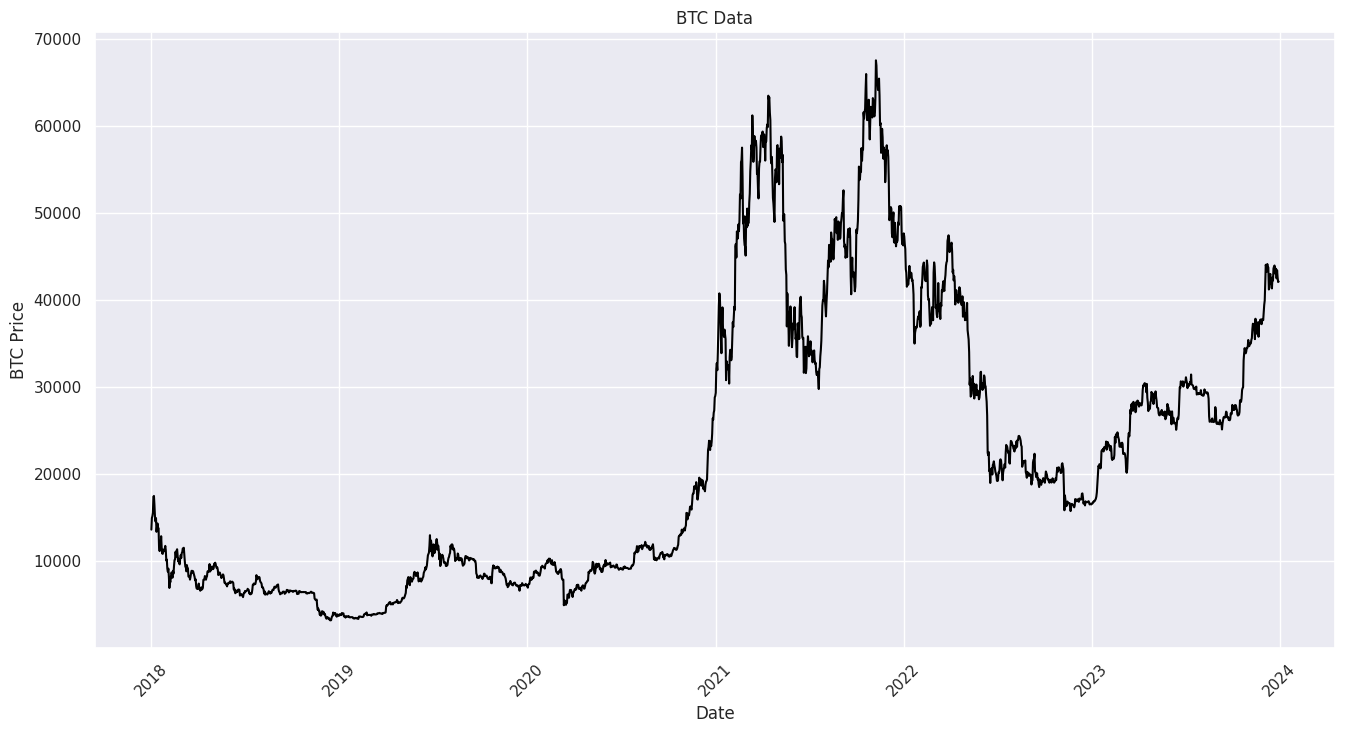

In [3]:
# pull Bitcoin price time series data
start_date = datetime.datetime(2018,1,1) #define the date range
end_date = datetime.datetime(2023,12,31)
btc = yf.download(['BTC-USD'], start = start_date, end=end_date)['Close'] #fetch the data
btc.to_csv('/content/sample_data/btc.csv') #write data to csv and avoid to repeatedly pull data
btc_data = pd.read_csv('/content/sample_data/btc.csv')
btc_data.index = pd.to_datetime(btc_data['Date'],format='%Y-%m-%d') #format date
btc_data.info()
del btc_data['Date']

#Visualization Data
sns.set()
plt.figure(figsize=(16,8))
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("BTC Data")
plt.plot(btc_data.index,btc_data['Close'], color= "black")
plt.show()

In [4]:
#Split data and define input
train_size = int(len(btc_data)*0.2)
train_data, test_data = btc_data[:train_size],btc_data[train_size:]

history_price = train_data['Close'].tolist()
test_price = test_data['Close'].tolist()

**Train Artificial intelligence Model**


*   Model Type: Traditional Statistical Models
*   Model Name: ARIMA





In [7]:
# fit the ARIMA model and make first prediction
ARIMA_predictions = list()
ARIMAmodel = ARIMA(history_price, order=(1,1,0))
ARIMAmodel_fit = ARIMAmodel.fit()
ARIMA_pred = ARIMAmodel_fit.forecast()[0]
ARIMA_predictions.append(ARIMA_pred) # add first prediction to list
history_price.append(test_price[0]) # add first observation to history for next loop

# using 'for' loop to roll forecasts
for i in range(1, len(test_price)):
    # predict
    model = ARIMA(history_price, order=(1,1,0))
    model_fit = model.fit()
    ARIMA_pred = model_fit.forecast()[0]
    # invert transformed prediction
    ARIMA_predictions.append(ARIMA_pred)
    # add actual observation to history for next loop
    obs = test_price[i]
    history_price.append(obs)

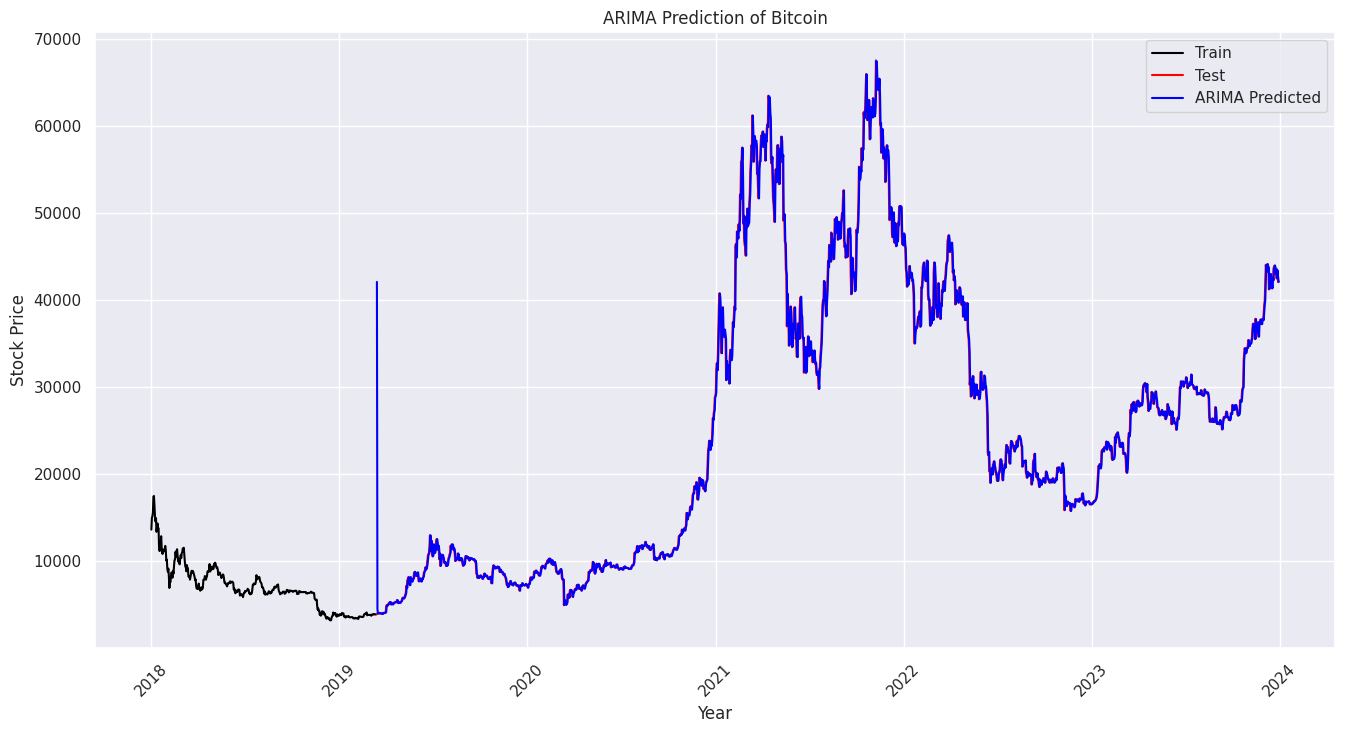

In [8]:
#Visualization Data of ARIMA prediction
plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data['Close'], color='black', label = 'Train')
plt.plot(test_data.index, test_data['Close'], color = 'red', label = 'Test')
plt.plot(test_data.index, ARIMA_predictions, color = 'blue', label = 'ARIMA Predicted')
plt.title('ARIMA Prediction of Bitcoin')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Train Artificial intelligence Model**


*   Model Type: Traditional Statistical Models
*   Model Name: GARCH

In [5]:
# fit the GARCH model and make first prediction
GARCH_predictions = []
garch_model = arch_model(history_price, vol='Garch', p=1, q=1, mean='Zero', rescale='True')
garch_fit = garch_model.fit(disp="off")
GARCH_pred = garch_fit.forecast(horizon=1)
GARCH_predictions.append(np.sqrt(GARCH_pred.variance.values[-1, 0])) # add first prediction to list


# Using 'for' loop to roll forecasts
for i in range(1, len(test_price)):
    # Add actual observation to history for next loop
    obs = test_price[i - 1]
    history_price.append(obs)

    # Predict
    garch_model = arch_model(history_price, vol='Garch', p=1, q=1, mean='Zero', rescale='True')
    garch_fit = garch_model.fit(disp="off")
    GARCH_pred = garch_fit.forecast(horizon=1)
    GARCH_predictions.append(np.sqrt(GARCH_pred.variance.values[-1, 0]))


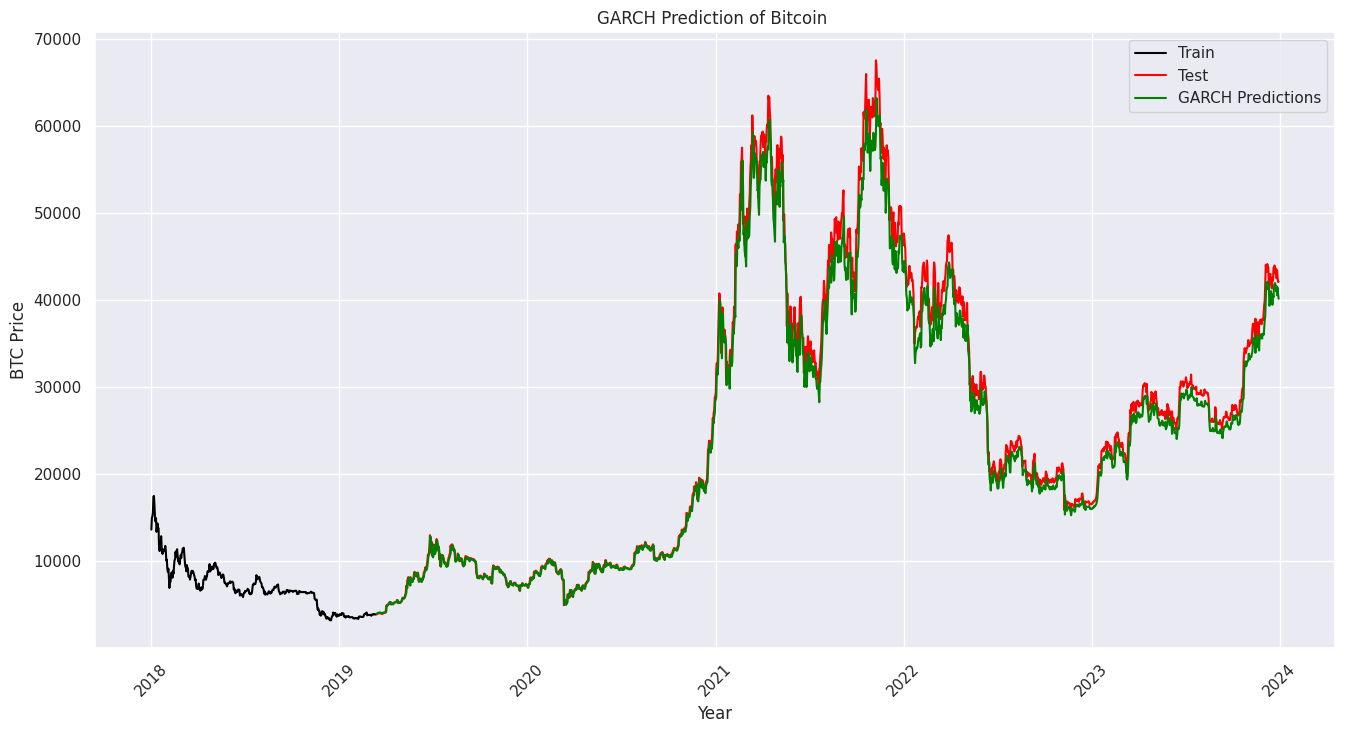

In [6]:
# Plotting
sns.set()
plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data['Close'], color='black', label = 'Train')
plt.plot(test_data.index, test_data['Close'], color = 'red', label = 'Test')
plt.plot(test_data.index, GARCH_predictions, color='green', label='GARCH Predictions')
plt.xlabel('Year')
plt.ylabel('BTC Price')
plt.title('GARCH Prediction of Bitcoin ')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

**Train Artificial intelligence Model**


*   Model Type: Hybrid Models
*   Model Name: ARIMA+GARCH

In [9]:
# Initialize the predictions list
ARIMA_GARCH_predictions = []

# Fit the initial ARIMA model
ARIMAmodel = ARIMA(history_price, order=(1, 1, 0))
ARIMAmodel_fit = ARIMAmodel.fit()

for i in range(len(test_price)):
    # Forecast the mean (ARIMA)
    arima_forecast = ARIMAmodel_fit.get_forecast(steps = 1)
    arima_forecast_mean = arima_forecast.predicted_mean

    # Get ARIMA model residuals
    residuals = ARIMAmodel_fit.resid

    # Fit the GARCH model to the residuals
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero', rescale='True')
    garch_fit = garch_model.fit(disp='off')
    # Forecast the variance (GARCH)
    garch_forecast = garch_fit.forecast(horizon=1)
    garch_forecast_variance = garch_forecast.variance.values[-1, 0]
    # Combine ARIMA and GARCH forecasts
    A_G_pred = arima_forecast_mean + np.sqrt(garch_forecast_variance)
    ARIMA_GARCH_predictions.append(A_G_pred)

    # Add actual observation to history for next loop
    history_price.append(test_price[i])

    # Refit the ARIMA model with the updated history
    ARIMAmodel = ARIMA(history_price, order=(1, 1, 0))
    ARIMAmodel_fit = ARIMAmodel.fit()

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

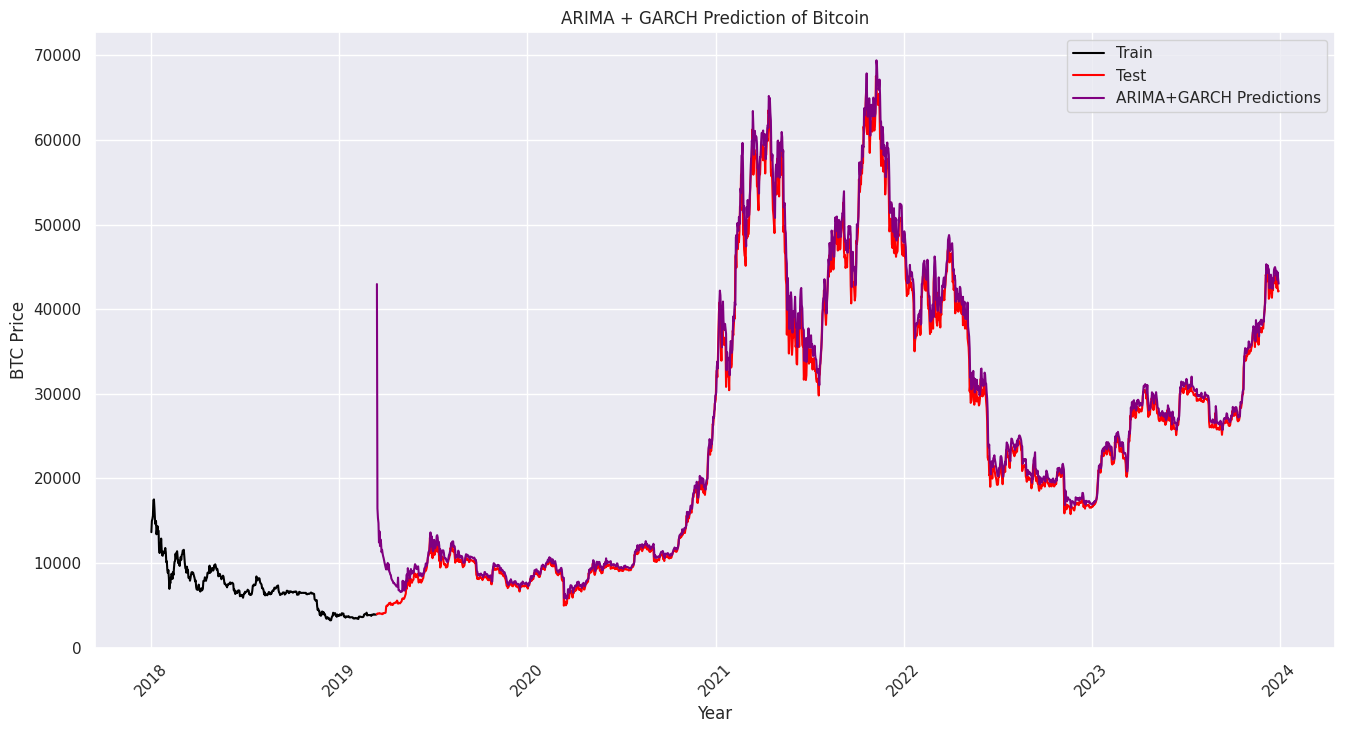

In [10]:
# Plot the original prices and the forecasted prices
sns.set()
plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data['Close'], color = "black", label='Train')
plt.plot(test_data.index, test_data['Close'], color = "red", label='Test')
plt.plot(test_data.index, ARIMA_GARCH_predictions, label='ARIMA+GARCH Predictions', color='purple')
plt.xlabel('Year')
plt.ylabel('BTC Price')
plt.xticks(rotation=45)
plt.title('ARIMA + GARCH Prediction of Bitcoin')
plt.grid(True)
plt.legend()
plt.show()

**RMSE evaluation of ARIMA, GARCH, ARIMA-GARCH  performance**




*   Model evaluation metrics:RMSE
*   AI models: ARIMA, GARCH, ARIMA-GARCH



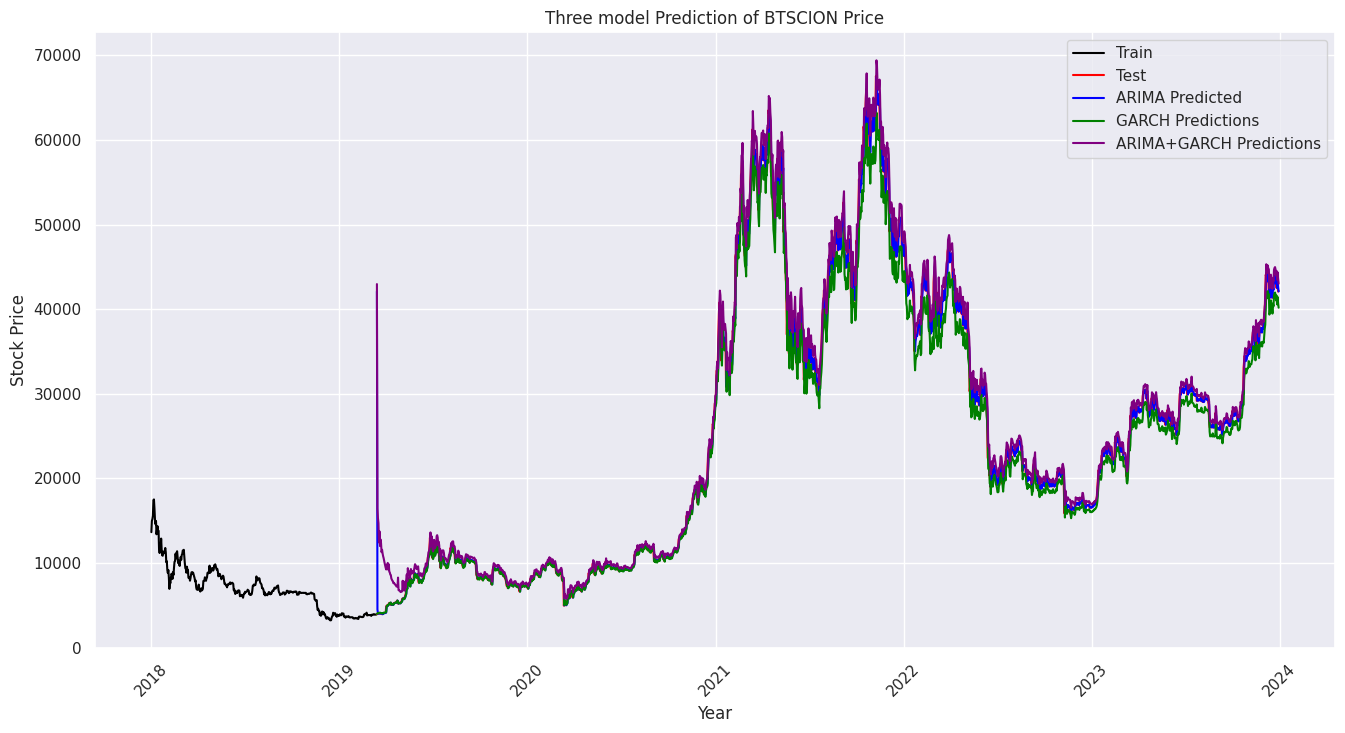

In [11]:
#Visualization Data of ARIMA prediction
plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data['Close'], color='black', label = 'Train')
plt.plot(test_data.index, test_data['Close'], color = 'red', label = 'Test')
plt.plot(test_data.index, ARIMA_predictions, color = 'blue', label = 'ARIMA Predicted')
plt.plot(test_data.index, GARCH_predictions, color='green', label='GARCH Predictions')
plt.plot(test_data.index, ARIMA_GARCH_predictions, label='ARIMA+GARCH Predictions', color='purple')
plt.title('Three model Prediction of BTSCION Price')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

RMSE evaluation of ARIMA:  1395.4324069520935
RMSE evaluation of GARCH:  1834.8385464413839
RMSE evaluation of ARIMA-GARCH:  1994.362804006414


<ipython-input-12-16495c544f68>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=rmse_df, palette='viridis')


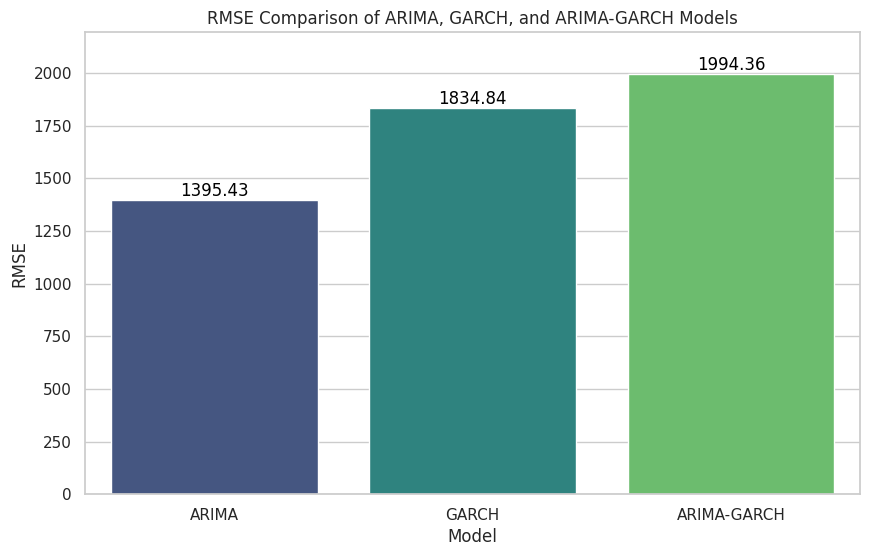

In [12]:
#Evaluate the performance of ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_price, ARIMA_predictions))
print("RMSE evaluation of ARIMA: ", arima_rmse)

#Evaluate the performance of GARCH
garch_rmse = np.sqrt(mean_squared_error(test_price, GARCH_predictions))
print("RMSE evaluation of GARCH: ", garch_rmse)

# Evaluate the performance of ARIMA-GARCH
arma_garch_rmse = np.sqrt(mean_squared_error(test_data['Close'], ARIMA_GARCH_predictions))
print("RMSE evaluation of ARIMA-GARCH: ", arma_garch_rmse)

# Create a DataFrame to store the RMSE values
rmse_data = {
    'Model': ['ARIMA', 'GARCH', 'ARIMA-GARCH'],
    'RMSE': [arima_rmse, garch_rmse, arma_garch_rmse]
}

rmse_df = pd.DataFrame(rmse_data)

# Visualize the RMSE values using a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=rmse_df, palette='viridis')

plt.title('RMSE Comparison of ARIMA, GARCH, and ARIMA-GARCH Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_df['RMSE']) + 0.1 * max(rmse_df['RMSE']))  # Set y-axis limit for better visualization

# Add RMSE values on top of the bars
for index, row in rmse_df.iterrows():
    plt.text(index, row['RMSE'] + 0.01 * max(rmse_df['RMSE']), round(row['RMSE'], 2), color='black', ha="center")

plt.show()


**MAPE evaluation of ARIMA, GARCH, ARIMA-GARCH  performance**
*   Model evaluation metrics:MAPE
*   AI models: ARIMA, GARCH, ARIMA-GARCH



MAPE evaluation of ARIMA:  0.028958619011274438 %
MAPE evaluation of GARCH:  0.041612875676359594
MAPE evaluation of ARIMA-GARCH:  0.07686497510796424


<ipython-input-13-ee5a74cd06bd>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAPE', data=mape_df, palette='viridis')


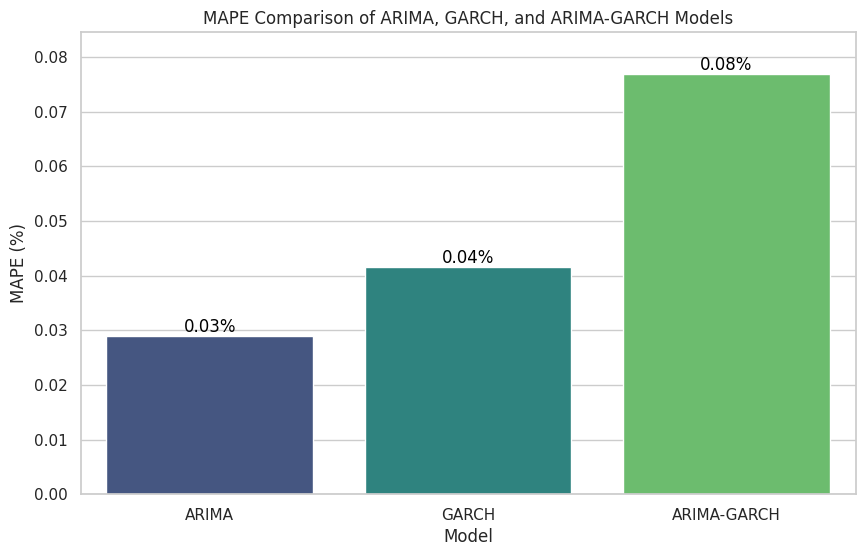

In [13]:
#Evaluate the performance of ARIMA
arima_mape = mean_absolute_percentage_error(test_price, ARIMA_predictions)
print("MAPE evaluation of ARIMA: ", arima_mape, "%")

#Evaluate the performance of GARCH
garch_mape = mean_absolute_percentage_error(test_price, GARCH_predictions)
print("MAPE evaluation of GARCH: ", garch_mape)

# Evaluate the performance of ARIMA-GARCH
arima_garch_mape = mean_absolute_percentage_error(test_data['Close'], ARIMA_GARCH_predictions)
print("MAPE evaluation of ARIMA-GARCH: ", arima_garch_mape)

# Create a DataFrame to store the MAPE values
mape_data = {
    'Model': ['ARIMA', 'GARCH', 'ARIMA-GARCH'],
    'MAPE': [arima_mape, garch_mape, arima_garch_mape]
}

mape_df = pd.DataFrame(mape_data)

# Visualize the MAPE values using a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=mape_df, palette='viridis')

plt.title('MAPE Comparison of ARIMA, GARCH, and ARIMA-GARCH Models')
plt.xlabel('Model')
plt.ylabel('MAPE (%)')
plt.ylim(0, max(mape_df['MAPE']) + 0.1 * max(mape_df['MAPE']))  # Set y-axis limit for better visualization

# Add MAPE values on top of the bars
for index, row in mape_df.iterrows():
    plt.text(index, row['MAPE'] + 0.01 * max(mape_df['MAPE']), f"{round(row['MAPE'], 2)}%", color='black', ha="center")

plt.show()

**MAE evaluation of ARIMA, GARCH, ARIMA-GARCH  performance**
*   Model evaluation metrics:MAE
*   AI models: ARIMA, GARCH, ARIMA-GARCH

MAE:  635.5848658419526
MAE:  1255.2988008028742
MAE:  1177.4188310227125


<ipython-input-14-0b91409ce684>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=mae_df, palette='viridis')


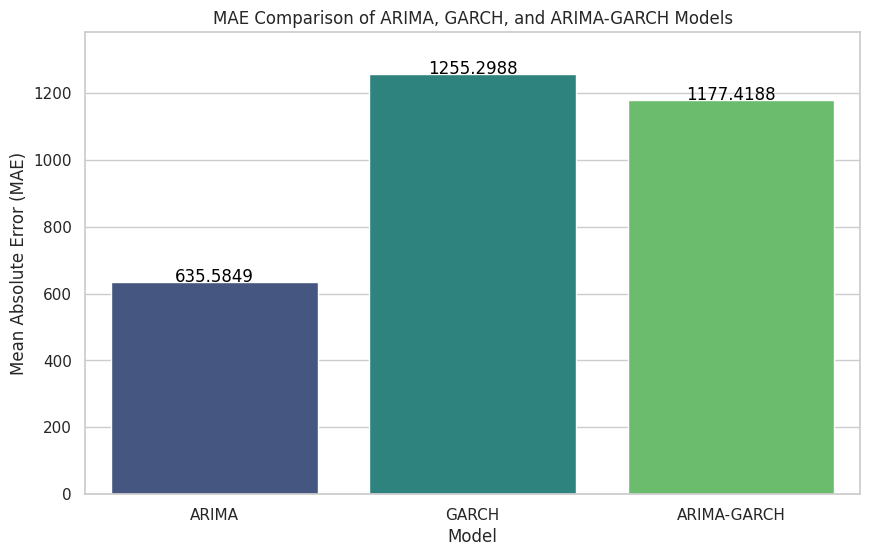

In [14]:
# Evaluate the performance of ARIMA using the mean absolute error
arima_mae = mean_absolute_error(test_price, ARIMA_predictions)
print("MAE: ", arima_mae)

# Evaluate the performance of GARCH using the mean absolute error
garch_mae = mean_absolute_error(test_price, GARCH_predictions)
print("MAE: ", garch_mae)

# Evaluate the performance of ARIMA-GARCH using the mean absolute error
arima_garch_mae = mean_absolute_error(test_price, ARIMA_GARCH_predictions)
print("MAE: ", arima_garch_mae)

# Create a DataFrame to store the MAE values
mae_data = {
    'Model': ['ARIMA', 'GARCH', 'ARIMA-GARCH'],
    'MAE': [arima_mae, garch_mae, arima_garch_mae]
}

mae_df = pd.DataFrame(mae_data)

# Visualize the MAE values using a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=mae_df, palette='viridis')

plt.title('MAE Comparison of ARIMA, GARCH, and ARIMA-GARCH Models')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(0, max(mae_df['MAE']) * 1.1)  # Adjust the limit to have some space above the bars

# Add MAE values on top of the bars
for index, row in mae_df.iterrows():
    plt.text(index, row['MAE'] + 0.02, f"{round(row['MAE'], 4)}", color='black', ha="center")

plt.show()

**R² evaluation of ARIMA, GARCH, ARIMA-GARCH  performance**
*   Model evaluation metrics:R²
*   AI models: ARIMA, GARCH, ARIMA-GARCH

R-squared:  0.9922046520301642
R-squared:  0.9865223675879732


<ipython-input-15-476791dc707e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R-squared', data=r2_df, palette='viridis')


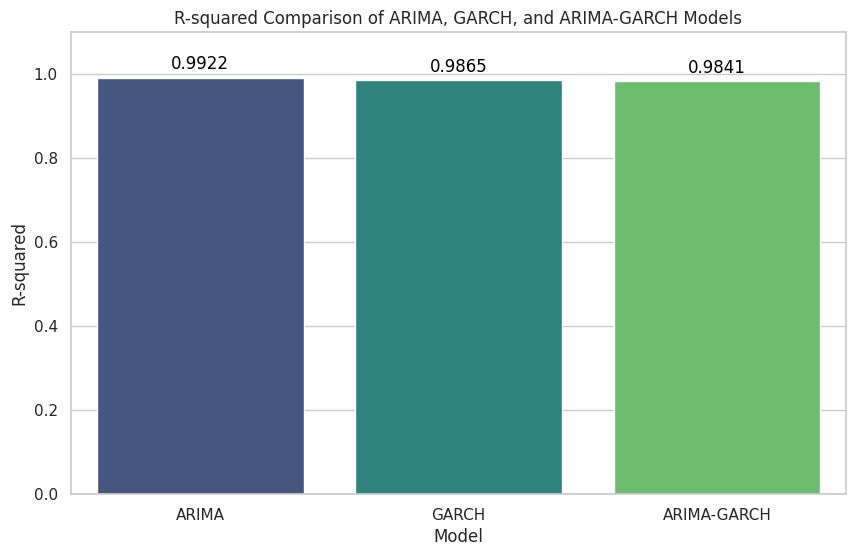

In [15]:
# Evaluate the performance of R² using R-square
arima_r2 = r2_score(test_price, ARIMA_predictions)
print("R-squared: ", arima_r2)

# Evaluate the performance of R² using R-square
garch_r2 = r2_score(test_price, GARCH_predictions)
print("R-squared: ", garch_r2)

# Evaluate the performance of R² using R-square
arima_garch_r2 = r2_score(test_price, ARIMA_GARCH_predictions)

# Create a DataFrame to store the R-squared values
r2_data = {
    'Model': ['ARIMA', 'GARCH', 'ARIMA-GARCH'],
    'R-squared': [arima_r2, garch_r2, arima_garch_r2]
}

r2_df = pd.DataFrame(r2_data)

# Visualize the R-squared values using a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R-squared', data=r2_df, palette='viridis')

plt.title('R-squared Comparison of ARIMA, GARCH, and ARIMA-GARCH Models')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.ylim(0, 1.1)  # R-squared values range between 0 and 1 and maje more space for number

# Add R-squared values on top of the bars
for index, row in r2_df.iterrows():
    plt.text(index, row['R-squared'] + 0.02, f"{round(row['R-squared'], 4)}", color='black', ha="center")

plt.show()